# CLL Morphology Analysis and Feature Selection
August 14, 2020

**Vladislav Kim**

Here we perform basic feature selection based on replicate correlation. Multiple replicates exist.

+ These plates are the same patient, screened in different plates on the same day:
    180306 Plate 5 and 180306 Plate 1
+ These plates are the same patient, but different aliquots, screened on different days:
    180306 Plate 3 and 180424 Plate 6
+ These plates are the same patient, screened in different plates on the same day:
    180213_Plate1 and 180213_Plate4
+ **Excluded due to low replicate correlation in terms of cell count (possibly segmentation errors)** These plates are the same patient, but different aliquots, screened on the same day:
    180504 Plate 6 and 180504 Plate 10

In [1]:
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os
import re
import sys
import h5py

javabridge.start_vm(class_path=bf.JARS)

In [2]:
from bioimg import load_imgstack, load_image_series, read_bbox
from sklearn.preprocessing import label_binarize

def get_train_instance(path, fname, columns=['ymin','xmin','ymax','xmax'], pad=0):
    imgstack = load_imgstack(fname=os.path.join(path, fname + ".png"),
                            verbose=False)
    img = np.squeeze(imgstack)
    df = pd.read_csv(os.path.join(path, fname + ".csv"))
    rmax, cmax, _ = img.shape
    bbox = read_bbox(df=df, rmax=rmax,
                     cmax=cmax, columns=columns,
                     pad=pad)
    return img, bbox

## Check Bounding Boxes of CLL Nuclei

In [3]:
path = '/Volumes/gitlab/microscopy/data/Sophie/Evaluations/'
plate = '180306_Plate1'

In [4]:
for f in os.listdir(path):
    if re.search(plate, f):
        screen_id = f

path = path + screen_id

In [5]:
df = pd.read_table(os.path.join(path, 'Evaluation5', 'Objects_Population - CLL cell nuclei.txt'), skiprows=9)

In [6]:
# remove objects with area less than 10 um^2
df = df[df['CLL cell nuclei - CLL Nuclei Area [µm²]'] > 10].reset_index(drop=True)

In [7]:
df['Row'] = df['Row'].astype(str)
df['Column'] = df['Column'].astype(str)
df['Field'] = df['Field'].astype(str)

In [8]:
df = df.assign(well=lambda x: 'r' + x['Row'].str.zfill(2) + 'c' + x['Column'].str.zfill(2))

In [9]:
df = df.assign(wellpos=lambda x: x['well'] + 'f' + x['Field'].str.zfill(2))

In [10]:
df = df[['well','wellpos', 'Bounding Box', 'X', 'Y']]

In [11]:
from ast import literal_eval
df[['xmin','ymin','xmax','ymax']] = pd.DataFrame(df['Bounding Box'].apply(lambda x: list(literal_eval(x))).tolist())

In [12]:
df.head()

,well,wellpos,Bounding Box,X,Y,xmin,ymin,xmax,ymax
0,r01c01,r01c01f01,"[924,1,952,35]",937,14,924,1,952,35
1,r01c01,r01c01f01,"[2059,48,2090,80]",2076,62,2059,48,2090,80
2,r01c01,r01c01f01,"[675,105,702,134]",688,118,675,105,702,134
3,r01c01,r01c01f01,"[1692,108,1727,140]",1707,123,1692,108,1727,140
4,r01c01,r01c01f01,"[1445,127,1489,175]",1467,150,1445,127,1489,175


In [13]:
all_wells = df['well'].unique()

In [14]:
imgdir = '/Volumes/gitlab/microscopy/data/Sophie/CLL/'
imgdir = os.path.join(imgdir, screen_id, 'Images')

In [15]:
fnames = [f for f in os.listdir(imgdir) if '.tiff' in f]
wfiles = [f for f in fnames if 'r01c02f01' in f and '(2)' not in f]

In [16]:
imgstack = load_image_series(path=imgdir, imgfiles=[w for w in wfiles if 'ch1' in w])
hoechst = np.max(imgstack, axis=0)
imgstack = load_image_series(path=imgdir, imgfiles=[w for w in wfiles if 'ch2' in w])
ly = np.max(imgstack, axis=0)

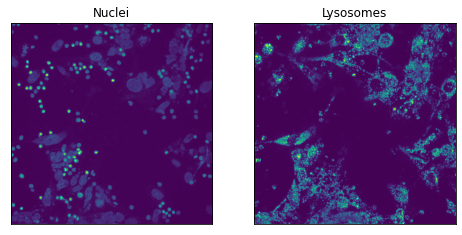

In [17]:
from bioimg import plot_channels
plot_channels([hoechst**0.5, ly**0.5],
              nrow=1, ncol=2,
              titles=['Nuclei', 'Lysosomes'])

In [18]:
from bioimg import combine_channels
col_params = dict(colors=['blue', 'white'],
                               blend = [1.5, 0.7],
                               gamma=[0.5, 0.4])
img_overlay = combine_channels([hoechst, ly],
                               **col_params)

In [19]:
well_df = df[df['wellpos']=='r01c02f01']

In [20]:
gamma = 0.3
hoechst = hoechst**gamma
ly = ly**gamma

In [21]:
rmax, cmax = hoechst.shape
bbox = read_bbox(df=well_df, rmax=rmax,
                 cmax=cmax, columns=['ymin','xmin','ymax','xmax'],
                 pad=5)

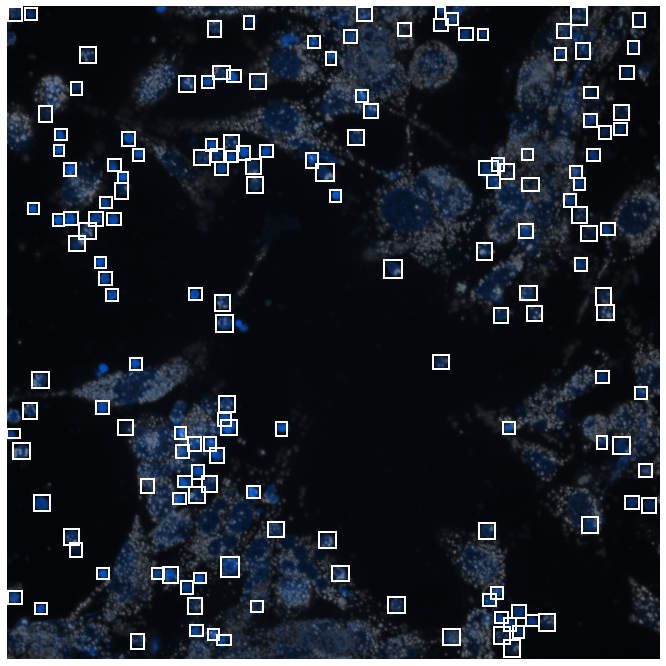

In [22]:
from bioimg import show_bbox
show_bbox(img=img_overlay, bbox=bbox)

In [23]:
from bioimg import ImgX
# initialize 'ImgX' class
imgx = ImgX(img=np.stack([hoechst, ly], axis=-1), 
            bbox=bbox,
            n_chan=['Hoechst', 'Lysosomal'])

In [24]:
imgx.compute_props()
img_df = imgx.get_df().copy()

In [25]:
img_df.shape

(160, 636)

## Explore DMSO Wells of 180306_Plate1

In [26]:
def load_CLL_cells(platedir, wells, annot, which=[1,2]):
    imgdf = []
    for w in wells:
        if os.path.isfile(os.path.join(platedir, w+'.csv')):
            df = pd.read_csv(os.path.join(platedir, w+'.csv'))
            df['well'] = w
            imgdf.append(df[np.isin(df['class'], which)])
    imgdf = pd.concat(imgdf).reset_index(drop=True)
    labels = imgdf[['class', 'well']]
    imgdf = imgdf.drop(['class', 'well'], axis=1)
    labels['class'] = labels['class'].apply(lambda x: 'Viable' if x == 2 else 'Apoptotic')    
    labels = pd.merge(labels, annot, on='well')
    return imgdf, labels

In [27]:
# load plate annotation
annot_df = pd.read_csv('../data/AML_trainset/drugannot.txt',
                      sep='\t')

In [28]:
annot_df.head()

,well,Drug,conc,Culture
0,r04c13,Bafilomycin A1,0.04,Mono-culture
1,r04c14,Bafilomycin A1,0.04,Co-culture
2,r04c11,Bafilomycin A1,0.60,Mono-culture
3,r04c12,Bafilomycin A1,0.60,Co-culture
4,r04c09,Bafilomycin A1,9.00,Mono-culture


In [29]:
dmso = annot_df[annot_df.Drug == 'DMSO'].reset_index(drop=True)
dmso_wells = dmso['well'].unique()

In [30]:
prefix = '../data/CLLdata/'

In [31]:
ctrl_df, ctrl_annot = load_CLL_cells(platedir=os.path.join(prefix,'180306_Plate1'),
                            wells=dmso_wells, annot=dmso)

In [32]:
ctrl_df.head()

,ch-Hoechst-area,ch-Hoechst-mean_intensity,ch-Hoechst-centroid-0,ch-Hoechst-centroid-1,ch-Hoechst-convex_area,ch-Hoechst-eccentricity,ch-Hoechst-equivalent_diameter,ch-Hoechst-euler_number,ch-Hoechst-extent,ch-Hoechst-orientation,...,ch-Lysosomal-zernike-r20-39,ch-Lysosomal-zernike-r20-40,ch-Lysosomal-zernike-r20-41,ch-Lysosomal-zernike-r20-42,ch-Lysosomal-zernike-r20-43,ch-Lysosomal-zernike-r20-44,ch-Lysosomal-zernike-r20-45,ch-Lysosomal-zernike-r20-46,ch-Lysosomal-zernike-r20-47,ch-Lysosomal-zernike-r20-48
0,917,0.600100,19.142857,20.354417,936,0.347059,34.169587,1,0.793253,0.400029,...,0.003168,0.008639,0.011977,0.018103,0.002467,0.004260,0.010378,0.011624,0.002861,0.006372
1,1279,0.283218,25.784206,26.059421,1307,0.545714,40.354348,1,0.760857,-0.916138,...,0.016298,0.012048,0.011049,0.003598,0.006923,0.016339,0.009672,0.006708,0.007724,0.000769
2,751,0.676055,18.880160,19.312916,768,0.354420,30.922531,1,0.807527,1.215867,...,0.008520,0.014553,0.007430,0.004473,0.009331,0.025673,0.002185,0.010617,0.005490,0.024957
3,2355,0.470074,31.165180,31.963907,2393,0.179991,54.758370,1,0.778512,1.524440,...,0.011529,0.005189,0.011986,0.007559,0.011899,0.008614,0.009264,0.007106,0.005931,0.001342
4,849,0.633834,23.206125,18.239105,984,0.566738,32.878266,1,0.640271,-0.131304,...,0.009569,0.007118,0.009418,0.006873,0.007991,0.008063,0.005657,0.003405,0.002937,0.011952


In [33]:
from bioimg.singlecell import select_features, preprocess_data
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=1e-8).fit(ctrl_df)

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:77: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [34]:
imgdf = preprocess_data(df=ctrl_df, sel=sel, glog=True)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [35]:
from sklearn.preprocessing import StandardScaler
from bioimg.singlecell import scale_data, check_data
scaler = StandardScaler().fit(X=imgdf)
imgdf_scaled = scale_data(imgdf, scaler=scaler)

In [36]:
check_data(imgdf_scaled)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pcs = PCA(n_components=20).fit_transform(imgdf_scaled)
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(pcs)

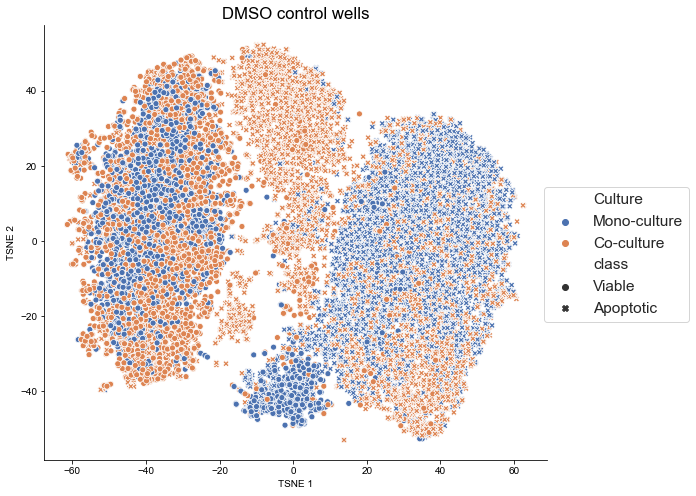

In [38]:
from bioimg.singlecell import plot_dimred
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), ctrl_annot], axis=1)

plot_dimred(X_df, 
            hue='Culture',
            style='class',
            style_order=['Viable', 'Apoptotic'],
            title='DMSO control wells')
plt.legend(loc='lower right',
           bbox_to_anchor=(1.3,0.3))

In [39]:
feat_subset = ['ch-Hoechst-area', 
               'ch-Hoechst-mean_intensity',
               'ch-Hoechst-perimeter',
               'ch-Hoechst-eccentricity',
               'ch-Hoechst-solidity',
               'ch-Lysosomal-mean_intensity']
Xfeat = imgdf_scaled.loc[:,feat_subset]
X_df = pd.concat([X_df, Xfeat], axis=1)

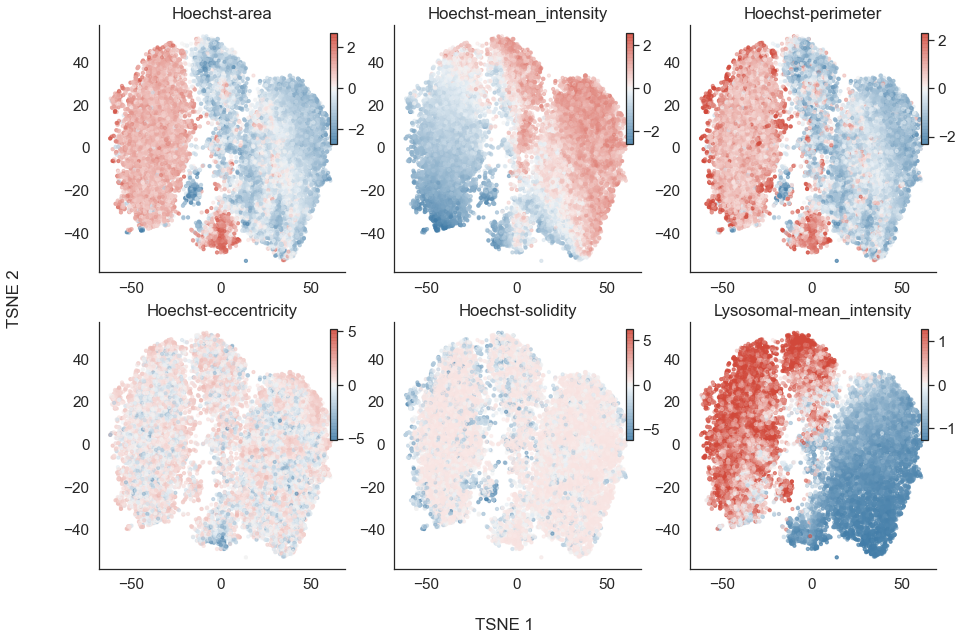

In [40]:
from bioimg.singlecell import facet_dimred
facet_dimred(X_df, feat_subset=feat_subset,
            nrows=2, ncols=3)

## Replicate Plates Screened on the same Day
For feature selection load only viable nuclei:

In [41]:
all_wells = annot_df['well'].values

In [42]:
rep1_df, rep1_annot = load_CLL_cells(platedir=os.path.join(prefix,'180306_Plate1'),
                            wells=all_wells, annot=annot_df, which=2)

In [43]:
rep1_df = preprocess_data(df=rep1_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep1_df[rep1_annot['Drug']=='DMSO'])
rep1_scaled = scale_data(rep1_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [44]:
rep2_df, rep2_annot = load_CLL_cells(platedir=os.path.join(prefix,'180306_Plate5'),
                            wells=all_wells, annot=annot_df, which=2)

In [45]:
rep2_df = preprocess_data(df=rep2_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep2_df[rep2_annot['Drug']=='DMSO'])
rep2_scaled = scale_data(rep2_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [46]:
rep1_df.shape[1] == rep2_df.shape[1]

True

In [47]:
rep1_scaled.shape[1] == rep2_scaled.shape[1]

True

In [48]:
from bioimg.singlecell import aggregate_profiles
prof_rep1 = aggregate_profiles(rep1_scaled, rep1_annot)
prof_rep2 = aggregate_profiles(rep2_scaled, rep2_annot)

In [49]:
# Make sure that the same wells are present in both replicates
prof_rep1 = prof_rep1[np.isin(prof_rep1['well'], prof_rep2['well'])]
prof_rep2 = prof_rep2[np.isin(prof_rep2['well'], prof_rep1['well'])]

In [50]:
def get_repcor(prof1, prof2):
    repcor = prof1.sort_values(by='well').corrwith(prof2.sort_values(by='well'))
    return repcor

In [51]:
repcor = get_repcor(prof_rep1, prof_rep2)

In [52]:
tech_rep1 = []
tech_rep2 = []

tech_rep1.append(prof_rep1)
tech_rep2.append(prof_rep2)

## Replicate Plates Screened on Different Days
For feature selection load only viable nuclei:

In [53]:
rep1_df, rep1_annot = load_CLL_cells(platedir=os.path.join(prefix,'180306_Plate3'),
                            wells=all_wells, annot=annot_df, which=2)

In [54]:
rep1_df = preprocess_data(df=rep1_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep1_df[rep1_annot['Drug']=='DMSO'])
rep1_scaled = scale_data(rep1_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [55]:
rep2_df, rep2_annot = load_CLL_cells(platedir=os.path.join(prefix,'180424_Plate6'),
                            wells=all_wells, annot=annot_df, which=2)

In [56]:
rep2_df = preprocess_data(df=rep2_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep2_df[rep2_annot['Drug']=='DMSO'])
rep2_scaled = scale_data(rep2_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [57]:
rep1_df.shape[1] == rep2_df.shape[1]

True

In [58]:
rep1_scaled.shape[1] == rep2_scaled.shape[1]

True

In [59]:
prof_rep1 = aggregate_profiles(rep1_scaled, rep1_annot)
prof_rep2 = aggregate_profiles(rep2_scaled, rep2_annot)

In [60]:
# Make sure that the same wells are present in both replicates
prof_rep1 = prof_rep1[np.isin(prof_rep1['well'], prof_rep2['well'])]
prof_rep2 = prof_rep2[np.isin(prof_rep2['well'], prof_rep1['well'])]

In [61]:
repcor = get_repcor(prof_rep1, prof_rep2)

In [62]:
tech_rep1.append(prof_rep1)
tech_rep2.append(prof_rep2)

## Replicate Plates Screened on the Same Day (sample with low viability)
For feature selection load only viable nuclei:

In [63]:
rep1_df, rep1_annot = load_CLL_cells(platedir=os.path.join(prefix,'180213_Plate1'),
                            wells=all_wells, annot=annot_df, which=2)

In [64]:
rep1_df = preprocess_data(df=rep1_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep1_df[rep1_annot['Drug']=='DMSO'])
rep1_scaled = scale_data(rep1_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [65]:
rep2_df, rep2_annot = load_CLL_cells(platedir=os.path.join(prefix,'180213_Plate4'),
                            wells=all_wells, annot=annot_df, which=2)

In [66]:
rep2_df = preprocess_data(df=rep2_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep2_df[rep2_annot['Drug']=='DMSO'])
rep2_scaled = scale_data(rep2_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [67]:
rep1_df.shape[1] == rep2_df.shape[1]

True

In [68]:
rep1_scaled.shape[1] == rep2_scaled.shape[1]

True

In [69]:
prof_rep1 = aggregate_profiles(rep1_scaled, rep1_annot)
prof_rep2 = aggregate_profiles(rep2_scaled, rep2_annot)

In [70]:
# Make sure that the same wells are present in both replicates
prof_rep1 = prof_rep1[np.isin(prof_rep1['well'], prof_rep2['well'])]
prof_rep2 = prof_rep2[np.isin(prof_rep2['well'], prof_rep1['well'])]

In [71]:
repcor = get_repcor(prof_rep1, prof_rep2)

In [72]:
tech_rep1.append(prof_rep1)
tech_rep2.append(prof_rep2)

In [73]:
repcor = get_repcor(pd.concat(tech_rep1).reset_index(drop=True), 
                    pd.concat(tech_rep2).reset_index(drop=True))

In [74]:
highcor = repcor[repcor > 0.5]
highcor_df = pd.DataFrame({'feature': highcor.index, 'repcor': highcor.values})
highcor_df['channel'] = np.NaN
highcor_df.loc[highcor_df['feature'].str.contains('Lysosomal'),'channel'] = 'Lysosomal'
highcor_df.loc[highcor_df['feature'].str.contains('Hoechst'),'channel'] = 'Hoechst'

In [75]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [76]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 9}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


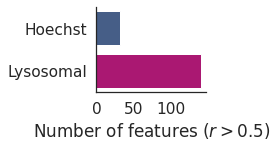

In [77]:
colors = ["denim blue", "magenta"]
pal = sn.xkcd_palette(colors)

plt.figure(figsize=cm2inch(5,4))
sn.barplot(data=highcor_df.groupby('channel', 
                                   as_index=False).agg('count'), 
           y='channel', x='feature', palette=pal)
plt.xlabel('Number of features ($r>0.5$)')
plt.ylabel('')
sn.set(style='white')
sn.despine()
#plt.savefig('../figures/CLL-repcor-features.pdf', bbox_inches='tight')

In [78]:
tech_rep1[0]['sample'] = tech_rep2[0]['sample'] = 'P0042'
tech_rep1[1]['sample'] = tech_rep2[1]['sample'] = 'P0487'
tech_rep1[2]['sample'] = tech_rep2[2]['sample'] = 'OMZP0134'

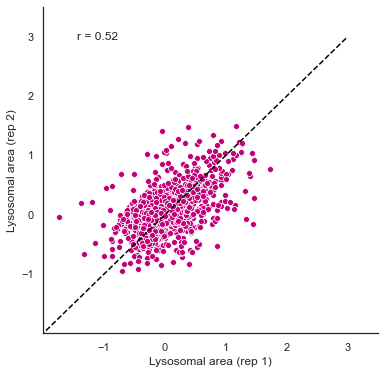

In [79]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([-3, 3], [-3, 3], linewidth=1.5, linestyle='--', color='black')
sn.scatterplot(x='ch-Lysosomal-area_x', y='ch-Lysosomal-area_y',
               data=pd.merge(pd.concat(tech_rep1)[['well', 'sample', 'ch-Lysosomal-area']],
                             pd.concat(tech_rep2)[['well', 'sample', 'ch-Lysosomal-area']],
                             on=['well', 'sample']), ax=ax,
              facecolor='#c20078')
sn.despine()
ax.annotate("r = {:.2f}".format(repcor['ch-Lysosomal-area']),
            xy=(.1, .9), xycoords=ax.transAxes)
ax.set_xlim((-2,3.5))
ax.set_ylim((-2,3.5))
plt.xlabel('Lysosomal area (rep 1)')
plt.ylabel('Lysosomal area (rep 2)')
xticks = ax.xaxis.get_major_ticks() 
xticks[0].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
sn.set(font_scale=1.4, style='white')

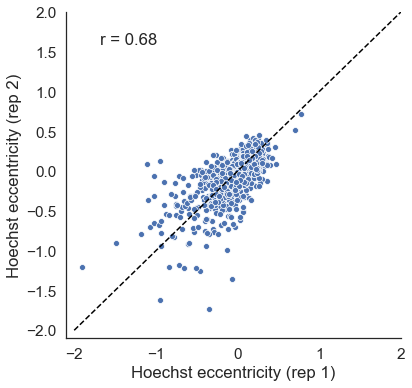

In [82]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([-2, 2], [-2, 2], linewidth=1.5, linestyle='--', color='black')
sn.scatterplot(x='ch-Hoechst-eccentricity_x', y='ch-Hoechst-eccentricity_y',
               data=pd.merge(pd.concat(tech_rep1)[['well', 'sample', 'ch-Hoechst-eccentricity']],
                             pd.concat(tech_rep2)[['well', 'sample', 'ch-Hoechst-eccentricity']], 
                             on=['well', 'sample']), ax=ax)
sn.despine()
ax.annotate("r = {:.2f}".format(repcor['ch-Hoechst-eccentricity']),
            xy=(.1, .9), xycoords=ax.transAxes)
ax.set_xlim((-2.1,2))
ax.set_ylim((-2.1,2))
plt.xlabel('Hoechst eccentricity (rep 1)')
plt.ylabel('Hoechst eccentricity (rep 2)')
xticks = ax.xaxis.get_major_ticks() 
xticks[0].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
sn.set(font_scale=1.4, style='white')

In [83]:
prof_rep1 = pd.concat(tech_rep1)
prof_rep2 = pd.concat(tech_rep2)

In [84]:
sel_feats = repcor[repcor > 0.5].index.values

In [85]:
# create a dictionary with various selected feature lists
featdict = dict()
featdict['repcor'] = sel_feats

In [86]:
X_subset = imgdf_scaled[sel_feats]

In [87]:
pcs = PCA(n_components=20).fit_transform(X_subset)
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(pcs)

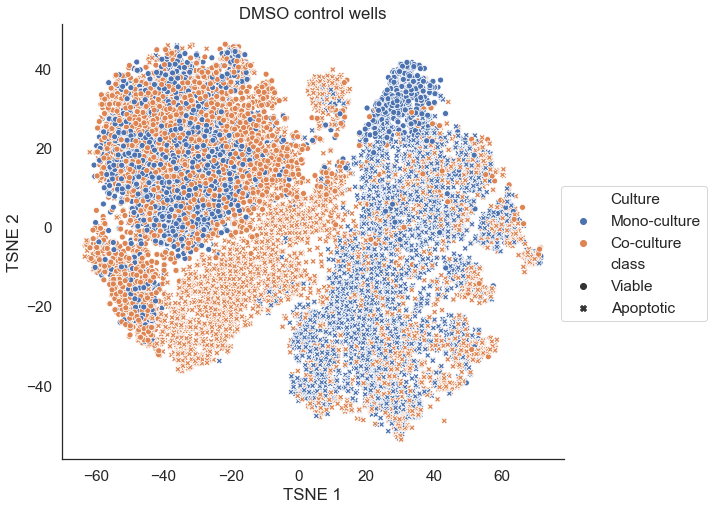

In [88]:
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), ctrl_annot], axis=1)

plot_dimred(X_df, 
            hue='Culture',
            style='class',
            style_order=['Viable', 'Apoptotic'],
            title='DMSO control wells')
plt.legend(loc='lower right',
           bbox_to_anchor=(1.3,0.3))

In [89]:
prof_rep1 = prof_rep1[sel_feats]
prof_rep2 = prof_rep2[sel_feats]

In [90]:
from bioimg.singlecell import select_residcor
sel_feats = select_residcor(prof1=prof_rep1, prof2=prof_rep2,
                            sel = ['ch-Hoechst-eccentricity', 
                                   'ch-Lysosomal-contrast-3'])

In [91]:
print("Number of selected features: %d" % len(sel_feats))

Number of selected features: 42


In [92]:
featdict['residcor'] = sel_feats

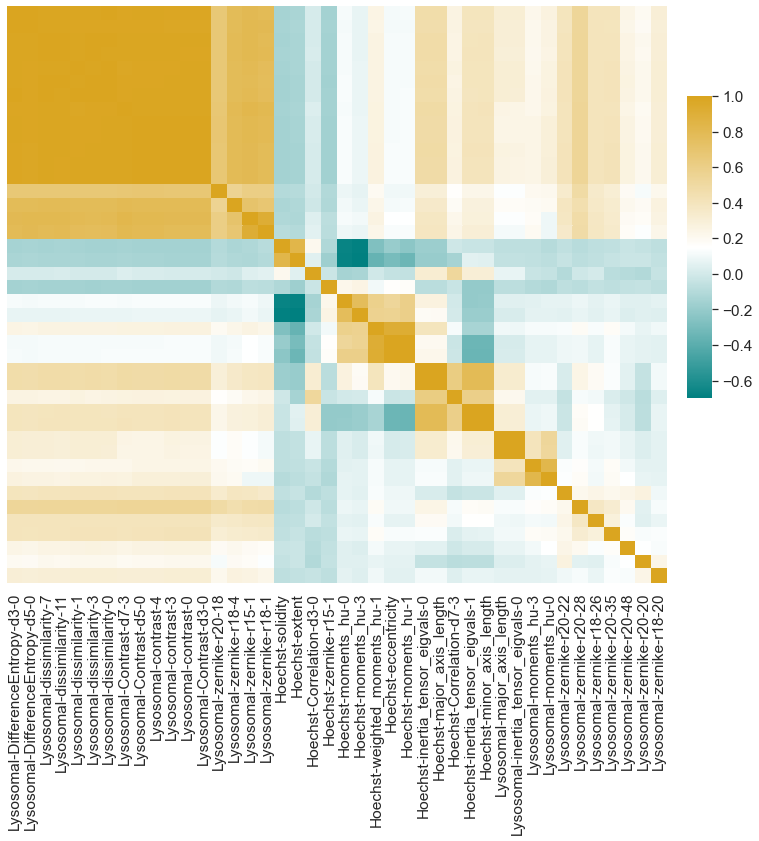

In [93]:
from bioimg.singlecell import plot_heatmap
X_subset = imgdf_scaled[sel_feats]
featnames = [f.replace('ch-', '') for f in X_subset.columns]
# feature correlation
featcor = pd.DataFrame(np.corrcoef(X_subset.T),
                       index=featnames,
                       columns=featnames )
plot_heatmap(featcor, xticklabels=True, size=(12,14))
plt.show()

In [94]:
feat_subset = ['ch-Hoechst-eccentricity', 
               'ch-Lysosomal-moments_hu-1',
               'ch-Hoechst-moments_hu-3',
               'ch-Hoechst-solidity',
               'ch-Hoechst-zernike-r20-1',
               'ch-Hoechst-InfoMeas1-d5-1',
               'ch-Lysosomal-zernike-r20-24',
               'ch-Lysosomal-area',
               'ch-Lysosomal-extent']
Xfeat = imgdf_scaled.loc[:,feat_subset]
X_df = pd.concat([X_df, Xfeat], axis=1)

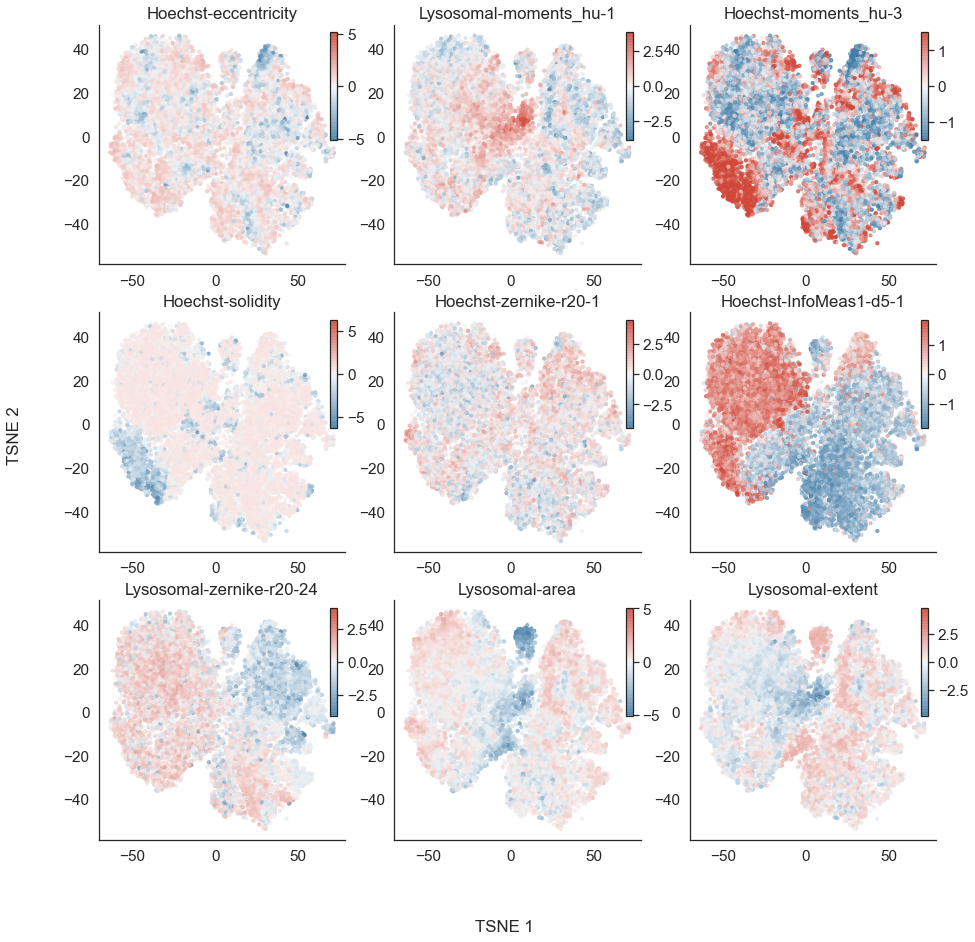

In [95]:
from bioimg.singlecell import facet_dimred
facet_dimred(X_df, feat_subset=feat_subset,
            nrows=3, ncols=3)

In [96]:
featdict = {k : v if type(v)==list else v.tolist() for k,v in featdict.items()}

In [97]:
# write selected features to a file
'''import json
with open('CLL-featselect.json', 'w') as fp:
    json.dump(featdict, fp)'''

"import json\nwith open('CLL-featselect.json', 'w') as fp:\n    json.dump(featdict, fp)"